# Mean Shift

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.patches as patches

In [9]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [3]:
def display_cluster_cir(X,km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X['theta'],X['r'],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X['theta'][km.labels_==i],X['r'][km.labels_==i],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

# Mean shift

In [6]:
class Mean_Shift(object):
    def __init__(self, bandwidth, data, dist='l2', kernel='G'):
        self.dist = dist
        self.bandwidth = bandwidth
        self.data = data
        self.kernel = kernel
        self.clusters = {}
        
        self.fig, self.ax = None, None
        self.circle_plot = None
        self.visualaize_x_hat = []
        self.visualaize_encircling_points = []
        self.visualaize_point = []
    
    def identify_norm(self):
        return int(self.dist.split('l')[1])
    
    def norm_p(self, centroid, w, data, norm=2, isNorm=False):                  
        distance = data.copy()
        encircling_points = 0
        for dim in range(data[0].shape[0], 0, -1):
            dim -= 1
            distance[:, dim] = np.power(data[:, dim]-centroid[dim], norm)
        
        distance = distance.sum(axis=1)
        distance = np.power(distance, 1/norm)
            
        if not isNorm:
            encircling_points = data[distance <= w]
        
        return encircling_points, centroid, distance    
    

    def fit(self):

        for point in self.data:
            _, cluster_center = self._itr(point)
            cluster_center = f"{(cluster_center[0], cluster_center[1])}"

            if cluster_center in self.clusters:
                self.clusters[cluster_center].append(point)
            else:
                self.clusters[cluster_center] = [point]

    def show(self):
        self.fig, self.ax = plt.subplots()
        self.ax.cla()
        color = 'brgcmyk'
        numbers = [0, 1, 2, 3, 4, 5]
        choice = 0
        print(f"number of clusters: {len(self.clusters.keys())}")
        for key in self.clusters.keys():

            p = np.array(self.clusters[key])
            self.ax.plot(p[:, 0], p[:, 1], 'o', color=color[choice])
            
            if choice != 5:
                choice +=1
        
    def _gausian_kernel(self, points, centeroid):
        cent_X = centeroid[0]
        cent_Y = centeroid[1]
        _, _, norm2 = self.norm_p(centroid=np.array((cent_X, cent_Y)), data=points, w=self.bandwidth, norm=2, isNorm=True)
        norm2 /= self.bandwidth
        norm2 = np.exp(-2 * np.power(norm2, 2))        
        result = np.multiply(np.power(2 * np.pi, -self.bandwidth/2), norm2)
        return result
    
    def _itr(self, point):
        x_hat = np.array((point[0], point[1]))
        
        while True:
            encircling_points, center, _ = self.norm_p(centroid=x_hat, w=self.bandwidth, data=self.data, norm=self.identify_norm())

            self.visualaize_x_hat.append(x_hat)
            self.visualaize_encircling_points.append(encircling_points)
            self.visualaize_point.append(point)                

            if self.kernel == 'G':
                # if len(encircling_points) > 0:
                fx = self._gausian_kernel(points=encircling_points, centeroid=x_hat)
                fx_d = np.reshape(fx, (fx.shape[0], 1))                                     
                fx = np.insert(fx_d, 1, fx,axis=1)                    

                subtract = encircling_points - center
                numerator = np.multiply(subtract, fx).sum(axis=0)
                denumerator = fx.sum()
                updated_mean = numerator / denumerator
                x_hat = updated_mean + x_hat
                   
                # else:
                    # center = x_hat
            
            if (x_hat==np.array([center])).all():
                # print(f"Convergence: point: {point}, center: {center}")
                return point, center
    
    def trace(self): 
        self.ax.cla()
        self.anim = FuncAnimation(self.fig, self.trace_data, frames=len(self.visualaize_point), interval=20, blit=True, init_func=self.draw_circle_area)
        HTML(self.anim.to_html5_video())
        rc('animation', html='html5')
        return self.anim
            
    def draw_circle_area(self):        
        redius=self.bandwidth 
        center=self.visualaize_x_hat[0]
        inner_points=self.visualaize_encircling_points[0]
        all_data=self.data
        isDataVisualization=False
        title='Fig'
        
        self.ax.set_title(title)
        self.lr, = self.ax.plot([], [], 'o', color='r', lw=2)
        self.ax.plot(all_data[:, 0], all_data[:, 1], 'o', color='y')
        
        self.lr.set_data(center[0], center[1])
        
        
        return (self.lr, )
        

    def trace_data(self, frame_number):
        center = self.visualaize_x_hat[frame_number]
        inner_points = self.visualaize_encircling_points[frame_number]
        all_data = self.data  
        title=f"point: {self.visualaize_point[frame_number]}"
        
        if self.circle_plot == None:
            self.circle_plot = plt.Circle((center[0], center[1]), self.bandwidth, color='b', fill=False)
            self.ax.add_patch(self.circle_plot)
        else:
            self.circle_plot.center = center[0], center[1]
        self.ax.set_title(title)
        # center
        self.lr.set_data(center[0], center[1])
        return (self.lr,)

              

number of clusters: 6


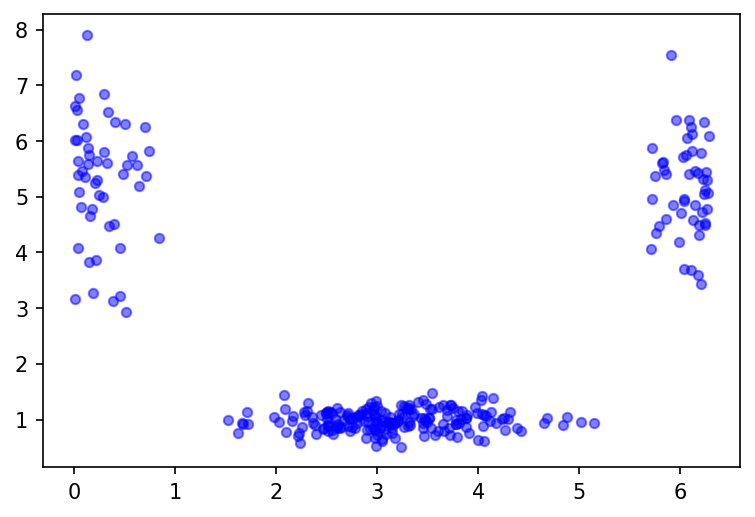

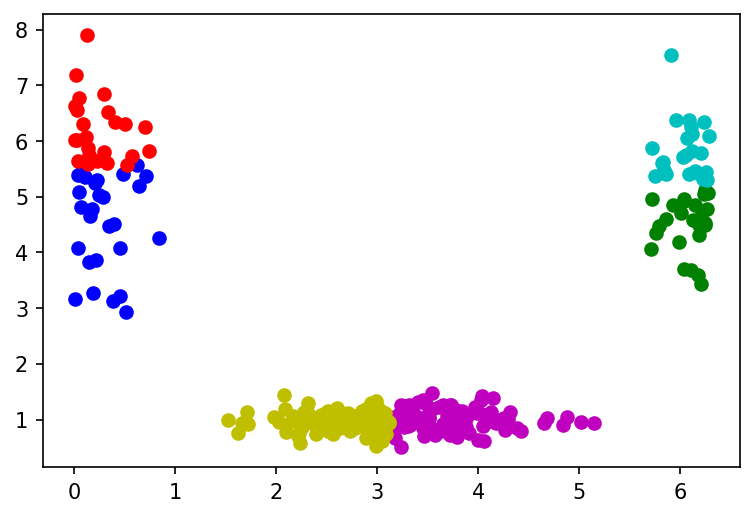

In [10]:
data = pd.read_csv('data_csv/data1.csv')
display_cluster_cir(data)
ms1 = Mean_Shift(bandwidth=2, data=data.to_numpy())
ms1.fit()
ms1.show()

In [ ]:
ms1.trace()

In [ ]:
data2 = pd.read_csv('data_csv/data2.csv')
display_cluster_cir(data2)
ms2 = Mean_Shift(bandwidth=2, data=data2.to_numpy())
ms2.fit()
ms2.show()

In [ ]:
ms2.trace()

In [ ]:
data3 = pd.read_csv('data_csv/data3.csv')
display_cluster_cir(data3)
ms3 = Mean_Shift(bandwidth=2, data=data3.to_numpy())
ms3.fit()
ms3.show()

In [ ]:
ms3.trace()

In [ ]:
data4 = pd.read_csv('data_csv/data4.csv')
display_cluster_cir(data4)
ms4 = Mean_Shift(bandwidth=2, data=data4.to_numpy())
ms4.fit()
ms4.show()

In [ ]:
ms4.trace()

In [ ]:
data5 = pd.read_csv('data_csv/data5.csv')
display_cluster_cir(data5)
ms5 = Mean_Shift(bandwidth=2, data=data5.to_numpy())
ms5.fit()
ms5.show()

In [ ]:
ms5.trace()

In [ ]:
data6 = pd.read_csv('data_csv/data6.csv')
display_cluster_cir(data6)
ms6 = Mean_Shift(bandwidth=2, data=data6.to_numpy())
ms6.fit()
ms6.show()

In [ ]:
ms6.trace()

In [ ]:
data7 = pd.read_csv('data_csv/data7.csv')
display_cluster_cir(data7)
ms7 = Mean_Shift(bandwidth=2, data=data7.to_numpy())
ms7.fit()
ms7.show()

In [ ]:
ms7.trace()